In [1]:
import numpy as np
import pandas as pd
import re
import itertools

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt


In [2]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pinky/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/pinky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/pinky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/pinky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#Reading the training data
df=pd.read_csv('data/train.csv')
df.head(10)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [4]:
# checking if any particular values are missing
print("Size of dataframe before cleanup: " + str(len(df)))
df.isnull().values.any()
df.dropna(axis=0, how='all', subset=['text', 'title'], inplace=True)
df.tail(10)
print("Size of dataframe after cleanup: " + str(len(df)))



Size of dataframe before cleanup: 20800
Size of dataframe after cleanup: 20800


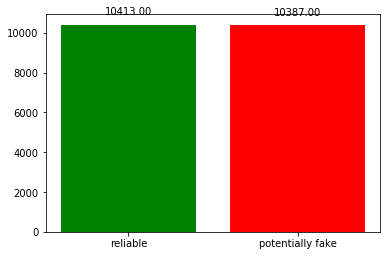

In [5]:
values = df['label'].value_counts()
plt.bar(x=["reliable", "potentially fake"], height=values, color=["green", "red"])
for x,y in zip(["reliable", "potentially fake"],values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()



In [6]:
df_reliable = df.loc[df['label'] == 0]
print(len(df_reliable))
df_reliable.tail(5)


10387


,id,title,author,text,label
20792,20792,"Jakarta Bombing Kills Three Police Officers, L...",John Hayward,Two suicide bombers attacked a bus station in ...,0
20794,20794,Trump: Putin ’Very Smart’ to Not Retaliate ove...,Lee Stranahan,Donald Trump took to Twitter Friday to praise ...,0
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0


In [7]:
df_fake = df.loc[df['label'] == 1]
print(len(df_fake))
df_fake.tail(5)

10413


,id,title,author,text,label
20788,20788,Maine’s Gov. LePage Threatens To ‘Investigate’...,Joe Clark,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
20791,20791,Lawyer Who Kept Hillary Campaign Chief Out of ...,Daniel Greenfield,Lawyer Who Kept Hillary Campaign Chief Out of ...,1
20793,20793,Idiot Who Destroyed Trump Hollywood Star Gets ...,Robert Rich,Share This \nAlthough the vandal who thought i...,1
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1
20799,20799,What Keeps the F-35 Alive,David Swanson,"David Swanson is an author, activist, journa...",1


In [8]:
df_titles_reliable = df_reliable['title']
print("Number of reliable titles before cleanup: " + str(len(df_titles_reliable)))
df_titles_reliable = df_titles_reliable.dropna()
print("Number of reliable titles after cleanup: " + str(len(df_titles_reliable)))
titles_reliable = list(df_titles_reliable)
cleaned_reliable_titles = [re.sub("[^\w\s]", " ", str(titles_reliable[i]).lower()) for i in range(len(titles_reliable))]

df_titles_fake = df_fake['title']
print("Number of fake titles before cleanup: " + str(len(df_titles_fake)))
df_titles_fake = df_titles_fake.dropna()
print("Number of fake titles after cleanup: " + str(len(df_titles_fake)))
titles_fake = list(df_titles_fake)
cleaned_fake_titles = [re.sub("[^\w\s]", " ", str(titles_fake[i]).lower()) for i in range(len(titles_fake))]




Number of reliable titles before cleanup: 10387
Number of reliable titles after cleanup: 10387
Number of fake titles before cleanup: 10413
Number of fake titles after cleanup: 9855


In [9]:
sia = SentimentIntensityAnalyzer()
sentimentscores = []
for i in cleaned_reliable_titles:
    score = sia.polarity_scores(i)
    score['title'] = i
    sentimentscores.append(score)
    
sentimentdf_reliable = pd.DataFrame(sentimentscores)

sentimentscores = []
for i in cleaned_fake_titles:
    score = sia.polarity_scores(i)
    score['title'] = i
    sentimentscores.append(score)
    
sentimentdf_fake = pd.DataFrame(sentimentscores)




In [10]:
sentimentdf_reliable.head(5)


,compound,neg,neu,pos,title
0,0.0000,0.000,1.000,0.000,flynn hillary clinton big woman on campus ...
1,0.5267,0.096,0.667,0.238,jackie mason hollywood would love trump if he...
2,0.7506,0.000,0.610,0.390,benoît hamon wins french socialist party s pre...
3,0.0000,0.000,1.000,0.000,excerpts from a draft script for donald trump ...
4,0.3612,0.000,0.848,0.152,a back channel plan for ukraine and russia co...


In [11]:
sentimentdf_fake.head(5)

,compound,neg,neu,pos,title
0,0.0000,0.000,1.000,0.000,house dem aide we didn t even see comey s let...
1,-0.3182,0.330,0.459,0.211,why the truth might get you fired
2,-0.6705,0.333,0.667,0.000,15 civilians killed in single us airstrike hav...
3,-0.7964,0.372,0.628,0.000,iranian woman jailed for fictional unpublished...
4,0.4588,0.000,0.833,0.167,life life of luxury elton john s 6 favorite ...


In [12]:
sentimentdf_reliable.drop(columns=['title'], inplace = True)
values_reliable = sentimentdf_reliable.mean()

sentimentdf_fake.drop(columns=['title'], inplace = True)
values_fake = sentimentdf_fake.mean()


Sentiment_analysis..



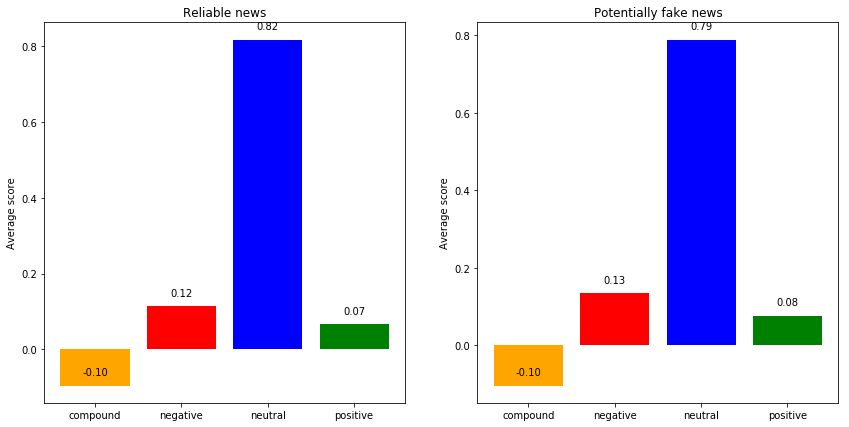

In [13]:
print("\nSentiment_analysis..\n")
names = ['compound', 'negative', 'neutral','positive']
colors=["orange", "red", "blue" , "green"]

plt.figure(figsize=(22, 7))
plt.subplot(131)
plt.bar(names,values_reliable, color=colors)
plt.title("Reliable news")
plt.ylabel("Average score")
# zip joins x and y coordinates in pairs
for x,y in zip(names,values_reliable):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.subplot(132)
plt.bar(names,values_fake, color=colors)
plt.title("Potentially fake news")
plt.ylabel("Average score")
for x,y in zip(names,values_fake):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

In [14]:
# Combining important features into a single feature
df['combined'] = df['title'] + ' ' + df['text']

df.head()

,id,title,author,text,label,combined
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [15]:
stop_words = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

for index, row in df.iterrows():
    filter_sentence = ''
    sentence = row['combined']
    # Cleaning the sentence with regex
    sentence = re.sub(r'[^\w\s]', '', str(sentence))
    # Tokenization
    words = nltk.word_tokenize(sentence)
    # Stopwords removal
    words = [w for w in words if not w in stop_words]
    # Lemmatization
    for words in words:
        filter_sentence = filter_sentence  + ' ' + str(lemmatizer.lemmatize(words)).lower()
    
    df.loc[index, 'total'] = filter_sentence

df.head()

,id,title,author,text,label,combined,total
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...,house dem aide we didnt even see comeys lette...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",flynn hillary clinton big woman campus breitb...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...,why truth might get you fired why truth might...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...,15 civilians killed in single us airstrike ha...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...,iranian woman jailed fictional unpublished st...


In [16]:
df['total'].head()


0     house dem aide we didnt even see comeys lette...
1     flynn hillary clinton big woman campus breitb...
2     why truth might get you fired why truth might...
3     15 civilians killed in single us airstrike ha...
4     iranian woman jailed fictional unpublished st...
Name: total, dtype: object

In [17]:
x_df = df['total']
y_df = df['label']

In [18]:
x_df.head()


0     house dem aide we didnt even see comeys lette...
1     flynn hillary clinton big woman campus breitb...
2     why truth might get you fired why truth might...
3     15 civilians killed in single us airstrike ha...
4     iranian woman jailed fictional unpublished st...
Name: total, dtype: object

In [19]:
y_df.head()


0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64

In [20]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(x_df)
freq_term_matrix = count_vectorizer.transform(x_df)

tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

print(tf_idf_matrix)

  (0, 182111)	0.014367201280927272
  (0, 181704)	0.048418361070662747
  (0, 181590)	0.009619071467985307
  (0, 180303)	0.043624647397204674
  (0, 180291)	0.07030944519825036
  (0, 180147)	0.03724363270754369
  (0, 180063)	0.013093065711151285
  (0, 179488)	0.01610935416663494
  (0, 179287)	0.05923617936454441
  (0, 178198)	0.014975162717779105
  (0, 178115)	0.02078689007866527
  (0, 177887)	0.016856000789372313
  (0, 177647)	0.012322447858113074
  (0, 177519)	0.033230160154084025
  (0, 177398)	0.05923617936454441
  (0, 177176)	0.0235502865210993
  (0, 177079)	0.01166255728947727
  (0, 175763)	0.02810400470828358
  (0, 175730)	0.02132989710142329
  (0, 175658)	0.01677535288901057
  (0, 174269)	0.021240481874801095
  (0, 172416)	0.06490082573830296
  (0, 171522)	0.05697340516520975
  (0, 171205)	0.03420731310260729
  (0, 170854)	0.017281102082393775
  :	:
  (20799, 10769)	0.020509719070340993
  (20799, 10765)	0.025969633363021983
  (20799, 10679)	0.030550730543341988
  (20799, 10590)	0.0

In [21]:
x_train, x_test, y_train, y_test = train_test_split(tf_idf_matrix,
                                   y_df, random_state=0)

In [22]:
y_train.head()


714      1
10601    1
20382    0
17723    0
17543    0
Name: label, dtype: int64

In [23]:
#LOGISTIC REGRESSION

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
Accuracy = logreg.score(x_test, y_test)

print(Accuracy*100)

95.82692307692308


In [24]:
#NAIVE BAYES

NB = MultinomialNB()
NB.fit(x_train, y_train)
Accuracy = NB.score(x_test, y_test)

print(Accuracy*100)

82.65384615384616


In [25]:
# DECISION TREE

clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
Accuracy = clf.score(x_test, y_test)

print(Accuracy*100)

94.71153846153845
